In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(7, 13), stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

#         self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)

#         self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
#         self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=2, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=(7, 13), stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
#         e1 = self.bn1(self.conv1(input))
#         e2 = self.bn2(self.conv2(e1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
#         e5 = self.bn5(self.conv5(e4))
#         e6 = self.conv6(e5)

#         return e6
#         print(input.shape)
#         m, indices = self.maxpool(input)
#         um = self.unpool(m, indices)
    
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
#         print(bn1.shape)
        
#         print(m3.shape)
        
#         print(um.shape)
#         print(bn1.shape)
        e2 = self.bn2(self.conv2(bn1))
#         print(e2.shape)
#         m3, indices =self.maxpool(bn1)
#         um = self.unpool(m3, indices)
        
        
#         
#         e5 = self.bn5(self.conv5(e2))
        e5 = self.bn5(self.conv5(e2))
#         print(e5.shape)
        e6 = self.conv6(e5)
#         print(e6.shape)

        return e6



In [3]:
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

model = Net()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

num_folds = 5
fold_num = 0
train, test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [4]:
train[:, 4, :, :].reshape(train.shape[0], 1, train.shape[2], -1).shape

(43, 1, 112, 24)

In [5]:
def reg_loss(pred, out):
    l1_loss = torch.sum(torch.abs(pred-out))  
    reg = 0.5*torch.sum(torch.abs(out))
    return l1_loss + reg

In [6]:
model = Net()

loss_fn = nn.L1Loss()
# loss_fun = reg_loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
app_idx = APPLIANCE_ORDER.index('dr')   
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, app_idx, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, app_idx, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()

In [19]:

for epoch in range(20000):
    
    pred = model(inp)
#     print(pred.shape)
#     pred = torch.clamp(pred, min=0.)
    loss = loss_fn(pred, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %100 == 0:
        
        
        test_pr = model(test_inp)
        test_pr = torch.clamp(test_pr, min=0.)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])
        print(test_pr.max())

0 Training Error: 72.9596939086914 Test Error: 51.35523223876953
Variable containing:
 12.7773
[torch.cuda.FloatTensor of size 1 (GPU 0)]

100 Training Error: 72.96648406982422 Test Error: 51.368892669677734
Variable containing:
 11.6401
[torch.cuda.FloatTensor of size 1 (GPU 0)]

200 Training Error: 72.9569091796875 Test Error: 51.36880874633789
Variable containing:
 12.5268
[torch.cuda.FloatTensor of size 1 (GPU 0)]

300 Training Error: 72.96088409423828 Test Error: 51.3642578125
Variable containing:
 11.9347
[torch.cuda.FloatTensor of size 1 (GPU 0)]

400 Training Error: 72.95893859863281 Test Error: 51.353271484375
Variable containing:
 12.6628
[torch.cuda.FloatTensor of size 1 (GPU 0)]

500 Training Error: 72.95964050292969 Test Error: 51.37793731689453
Variable containing:
 12.6537
[torch.cuda.FloatTensor of size 1 (GPU 0)]

600 Training Error: 72.9473648071289 Test Error: 51.3509521484375
Variable containing:
 13.0204
[torch.cuda.FloatTensor of size 1 (GPU 0)]

700 Training Erro

5800 Training Error: 72.91522216796875 Test Error: 51.389957427978516
Variable containing:
 15.1595
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5900 Training Error: 72.9119873046875 Test Error: 51.38237762451172
Variable containing:
 14.7557
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6000 Training Error: 72.9159164428711 Test Error: 51.388710021972656
Variable containing:
 13.9706
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6100 Training Error: 72.90699768066406 Test Error: 51.38702392578125
Variable containing:
 14.4810
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6200 Training Error: 72.92496490478516 Test Error: 51.392356872558594
Variable containing:
 13.4334
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6300 Training Error: 72.92390441894531 Test Error: 51.38497543334961
Variable containing:
 13.8490
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6400 Training Error: 72.92230224609375 Test Error: 51.37434005737305
Variable containing:
 14.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11600 Training Error: 72.82244873046875 Test Error: 51.40083694458008
Variable containing:
 95.3639
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11700 Training Error: 72.81619262695312 Test Error: 51.400001525878906
Variable containing:
 110.7550
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11800 Training Error: 72.81141662597656 Test Error: 51.42491912841797
Variable containing:
 119.8977
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11900 Training Error: 72.81536865234375 Test Error: 51.388092041015625
Variable containing:
 134.2268
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12000 Training Error: 72.78959655761719 Test Error: 51.395347595214844
Variable containing:
 146.8051
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12100 Training Error: 72.78628540039062 Test Error: 51.42151641845703
Variable containing:
 170.8452
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12200 Training Error: 72.76091766357422 Test Error: 51.41342544555664
Variable containing:
 187.3010
[torch.cuda.FloatTensor of 

17300 Training Error: 71.08656311035156 Test Error: 51.92515563964844
Variable containing:
 5988.6123
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17400 Training Error: 70.60678100585938 Test Error: 51.890987396240234
Variable containing:
 5800.9160
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17500 Training Error: 70.53671264648438 Test Error: 52.04145050048828
Variable containing:
 6327.4429
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17600 Training Error: 70.46287536621094 Test Error: 51.92137145996094
Variable containing:
 5854.2158
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17700 Training Error: 71.21437072753906 Test Error: 52.02033615112305
Variable containing:
 6506.3813
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17800 Training Error: 70.49613189697266 Test Error: 52.04108810424805
Variable containing:
 6252.4180
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17900 Training Error: 70.95877075195312 Test Error: 52.047882080078125
Variable containing:
 6507.9980
[torch.cuda.FloatTen

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [20]:
test_pr = torch.clamp(test_pr, min=0.)
pred = torch.clamp(pred, min=0.)

14


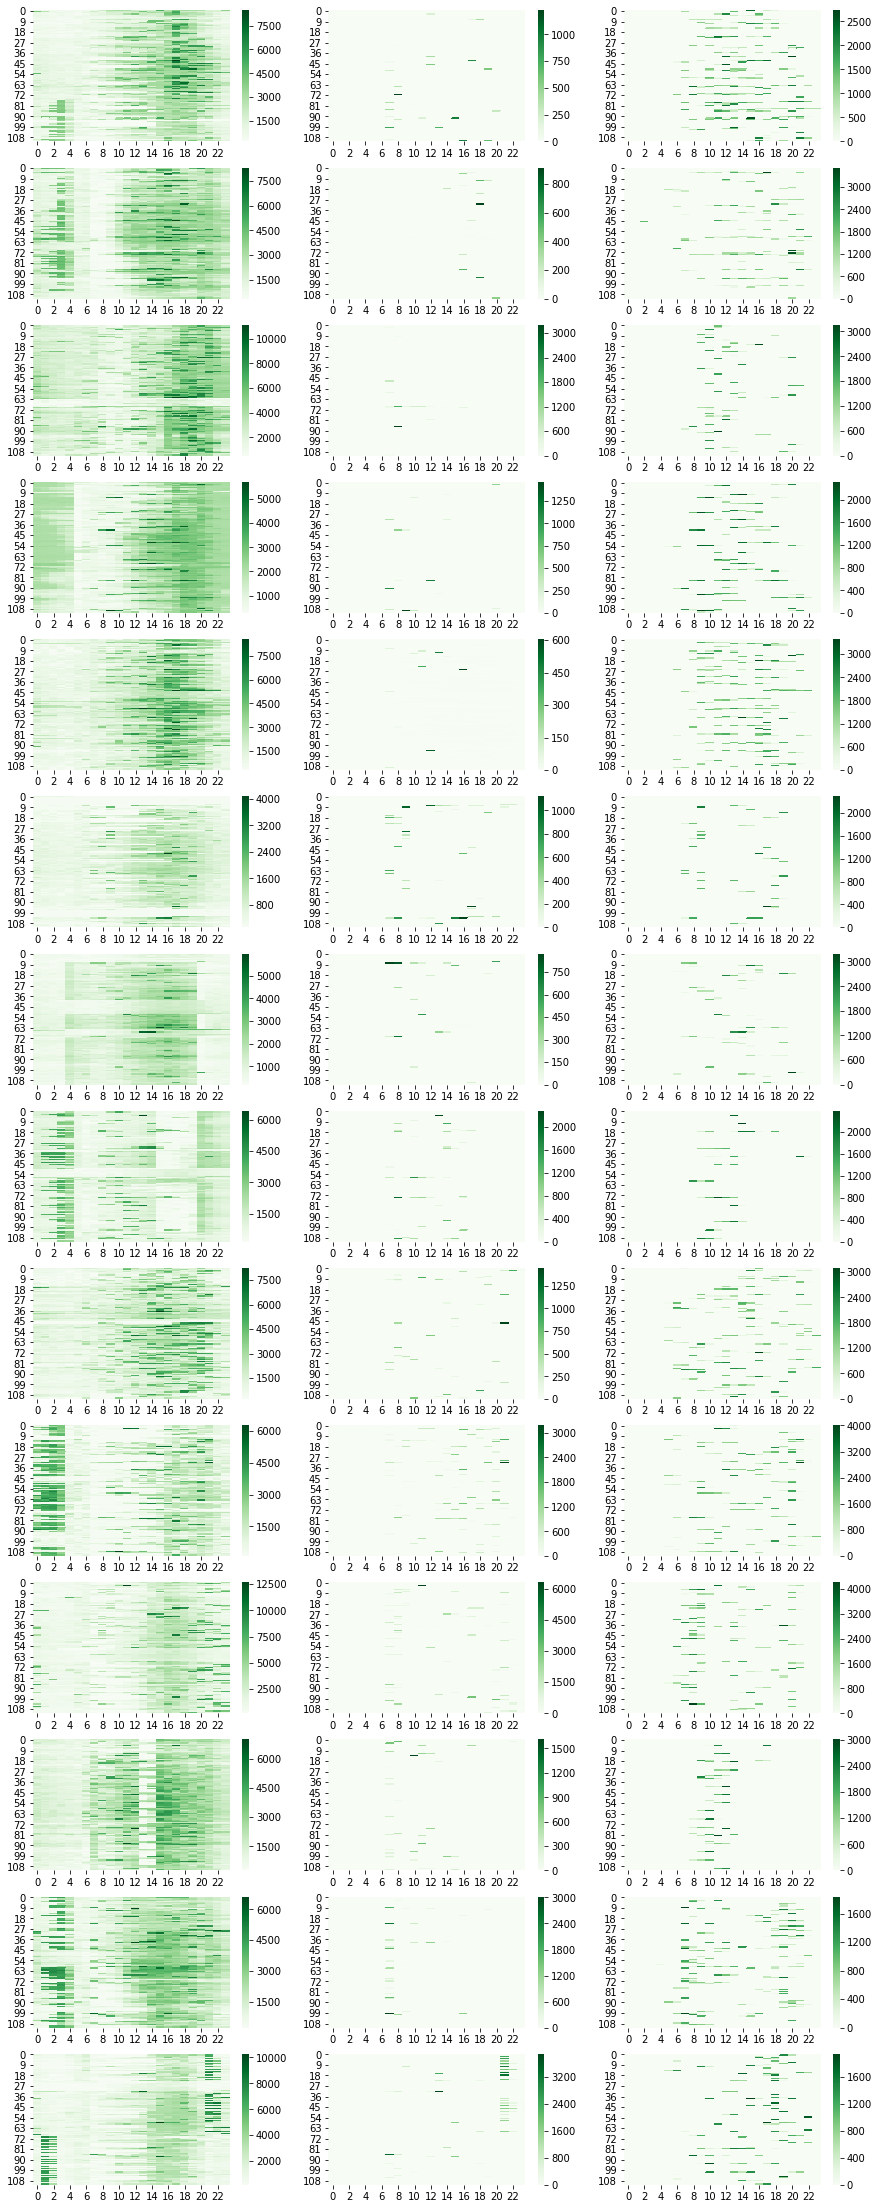

In [21]:
num_test = test_pr.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




In [ ]:
num_train = pred.cpu().data.numpy().shape[0]
num_test = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=9,ncols=3, figsize=(15, 20))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




43


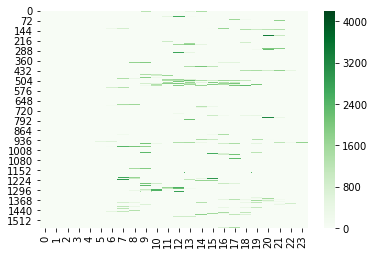

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')